### Evaluation notebook for trained and saved models

In [40]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=''
import numpy as np
import torch
from torch import nn
from mapsgan import SGANSolver, data_loader, BicycleGenerator, BicycleSolver
from mapsgan.sgan import TrajectoryGenerator, TrajectoryDiscriminator
import mapsgan.experiments as experiments
from mapsgan.evaluation import Visualization
from pathlib import Path
from mapsgan.utils import get_sgan_generator, smooth_data
import os, glob
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: CUDA_VISIBLE_DEVICES=''


In [2]:
torch.cuda.is_available()

False

### Set these manually according to the script

In [3]:
mode = 'cvae'
fileprefix = '/cloud/sgan_bicy_2'
lr_gen = 1e-3
lr_dis = 1e-3
lr_enc = 1e-3
loss_weights = {'disc': 1, 'traj': 1, 'kl': 0.01, 'z': 0.5}
obs_len = 8,
pred_len = 12
embedding_dim = 16
encoder_h_dim = 32
decoder_h_dim = 32
mlp_dim = 64
num_layers = 1
noise_dim = (8,)
noise_type = 'gaussian'
noise_mix_type = 'global'
pooling_type = 'pool_net'

In [5]:
root_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
filesearch = root_path + '/models' + fileprefix + '*5000*' # can change here acc to saved epoch
filelist = glob.glob(filesearch)
filename = filelist[0]

In [6]:
filename

'/home/yy/ADL4CV/mapsgan/models/cloud/sgan_bicy_2_20190205-202612_epoch_5000'

### Initializing dataloader, models, solver

In [35]:
experiment = experiments.ETH() # we store filepaths and arguments in here
dataset, trainloader = data_loader(in_len=8, out_len=12, batch_size=64, num_workers=1, path=experiment.train_dir,
                                  shuffle=True)
_ , testloader = data_loader(in_len=8, out_len=12, batch_size=1, num_workers=1, path=experiment.test_dir,
                                  shuffle=False)

In [15]:
model_path = '../../sgan/sgan/models/sgan-p-models/'
model = 'eth_12_model.pt'
###
checkpoint = torch.load(model_path + model, map_location='cpu')
generator_sgan = get_sgan_generator(checkpoint)
generator = BicycleGenerator(generator=generator_sgan,
                             start_mode=mode,
                             embedding_dim=embedding_dim,
                             h_dim=decoder_h_dim - 8,
                             z_dim=8,
                             in_len=obs_len,
                             out_len=pred_len,
                             noise_type=noise_type,
                             noise_mix_type=noise_mix_type)

discriminator = TrajectoryDiscriminator(obs_len=8,
                                        pred_len=12,
                                        embedding_dim=16,
                                        h_dim=64,
                                        mlp_dim=64,
                                        num_layers=1,
                                        dropout=0,
                                        batch_norm=0,
                                        d_type='local')

In [18]:
solver = BicycleSolver(generator, discriminator,
                       loss_weights=loss_weights,
                       optims_args={'generator': {'lr': lr_gen},
                                    'discriminator': {'lr': lr_dis},
                                    'encoder': {'lr': lr_enc}})

### Looking at losses

In [19]:
epochs = solver.load_checkpoint(filename)

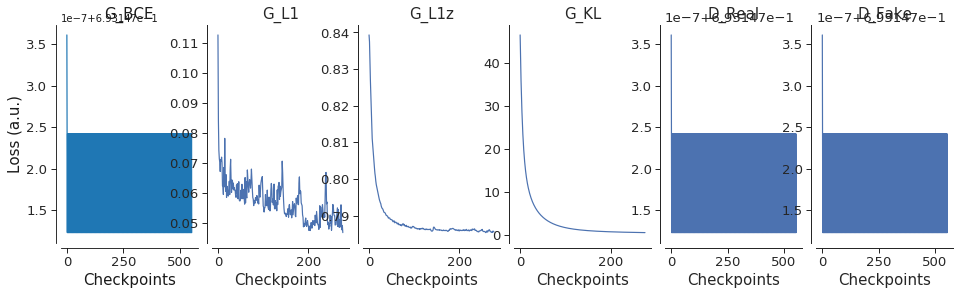

In [20]:
vis = Visualization()
vis.loss(solver.train_loss_history)

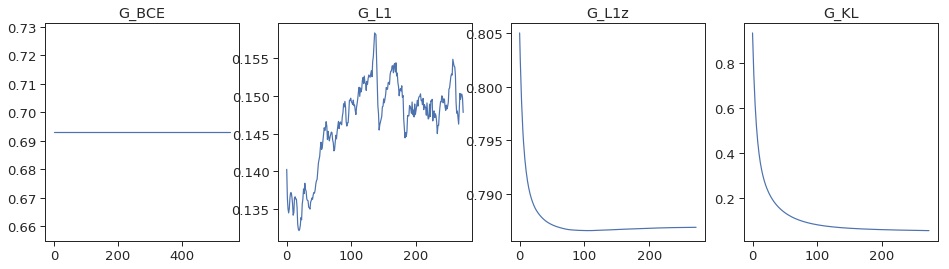

In [29]:
vis = Visualization()
vis.loss_val(solver.train_loss_history['validation']['generator'])

### Looking at predictions

In [30]:
output = solver.test(testloader, load_checkpoint_from=filename) #can also use trainloader for overfit

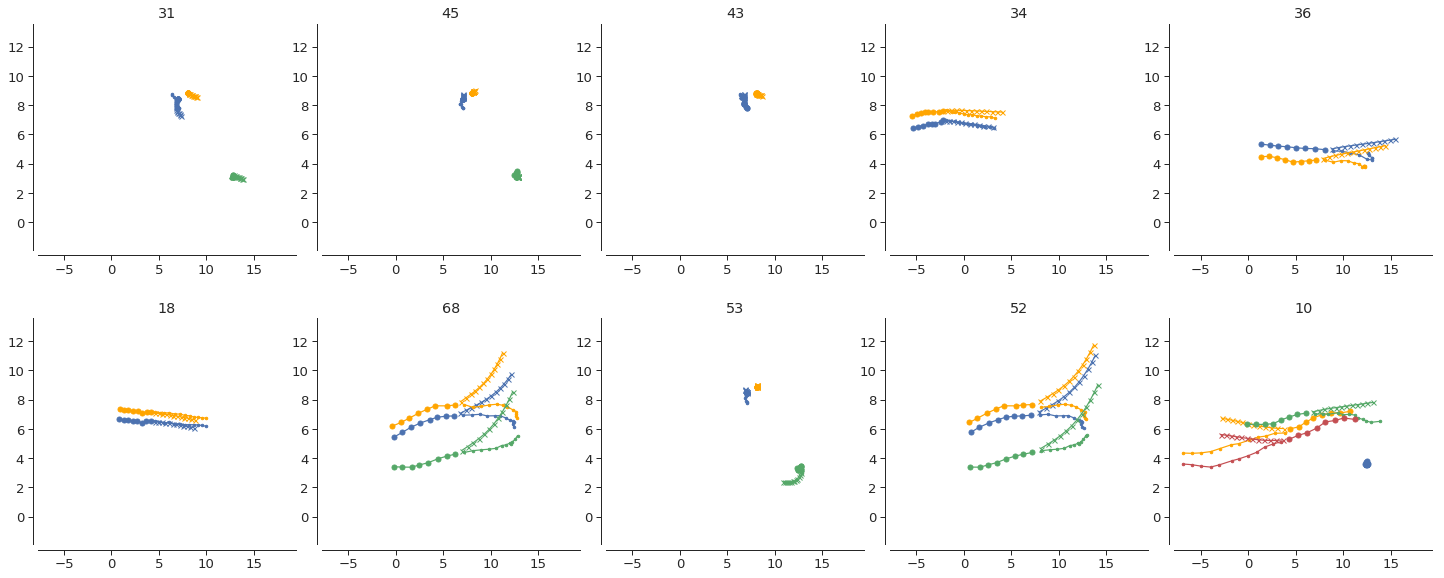

In [36]:
vis = Visualization()
ll = vis.trajectories(output, scenes=10, input_truth=True, ground_truth=True)

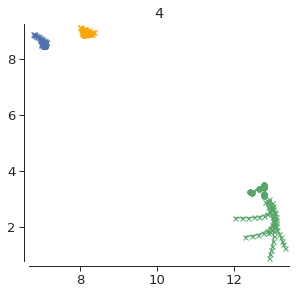

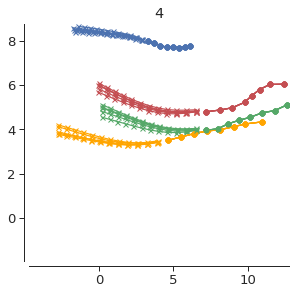

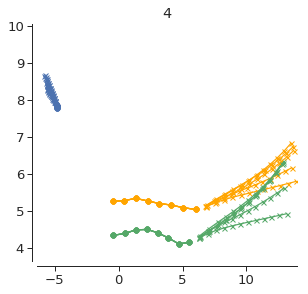

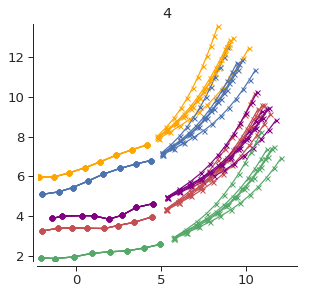

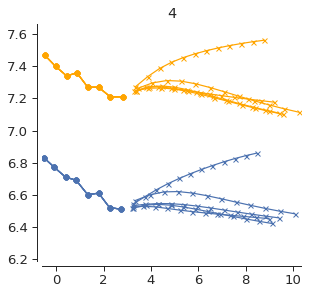

In [39]:
for s in [3,25,30,44,65]:
    predictions = solver.sample_distribution(testloader, scene=s, seed=10, z_dim=8, num_samples=5)
    vis.trajectories(predictions, scenes=None, input_truth=True, dist=True )
    plt.show()

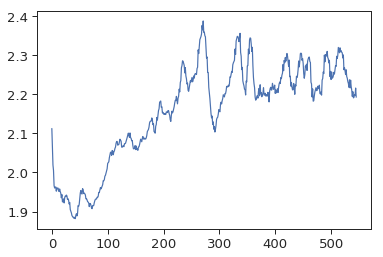

In [42]:
plt.plot(smooth_data(solver.train_loss_history['validation']['fde'], 10))

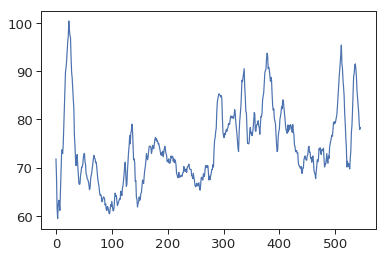

In [47]:
plt.plot(smooth_data(solver.train_loss_history['validation']['collisions'], 10))